# Snowflake

```{important}
`snowflake-sqlalchemy` requires SQLAlchemy 1.x (as of version 1.4.7 )
```

`Snowflake` is a cloud-based data warehousing platform that provides organizations with a powerful and flexible solution for storing, managing, and analyzing large amounts of data. Unlike traditional data warehouses, Snowflake operates entirely in the cloud, utilizing a distributed architecture that allows it to process and store data across multiple computing resources. 

In this guide, we'll demonstrate how to integrate with Snowflake using JupySQL magics.

```{tip}
If you encounter any issues, feel free to join our [community](https://ploomber.io/community) and we'll be happy to help!
```

## Pre-requisites

We will need the `snowflake-sqlalchemy` package for connecting to the warehouse.

In [1]:
%pip install --upgrade snowflake-sqlalchemy 'sqlalchemy<2' --quiet

Note: you may need to restart the kernel to use updated packages.


Now let's define the URL connection parameters and create an `Engine` object.

In [17]:
from sqlalchemy import create_engine
from snowflake.sqlalchemy import URL


engine = create_engine(
    URL(
        drivername="driver",
        user="user",
        password="password",
        account="account",
        database="database",
        role="role",
        schema="schema",
        warehouse="warehouse",
    )
)

## Load sample data

Now, let's load the `penguins` dataset. We'll convert this `.csv` file to a dataframe and create a table in Snowflake database from the data.

In [3]:
import urllib.request

urllib.request.urlretrieve(
    "https://raw.githubusercontent.com/mwaskom/seaborn-data/master/penguins.csv",
    "penguins.csv",
)

('penguins.csv', <http.client.HTTPMessage at 0x12ea1f100>)

In [4]:
%load_ext sql

In [5]:
%sql engine --alias connection

In [6]:
import pandas as pd

df = pd.read_csv("penguins.csv")
connection = engine.connect()
df.to_sql(name="penguins", con=connection, index=False, if_exists="replace")

344

## Query

List the tables in the database:

In [7]:
%sqlcmd tables

Name
penguins


List columns in the penguins table:

In [8]:
%sqlcmd columns --table penguins

name,type,nullable,default,autoincrement,comment,primary_key
species,VARCHAR(16777216),True,None,False,None,False
island,VARCHAR(16777216),True,None,False,None,False
bill_length_mm,FLOAT,True,None,False,None,False
bill_depth_mm,FLOAT,True,None,False,None,False
flipper_length_mm,FLOAT,True,None,False,None,False
body_mass_g,FLOAT,True,None,False,None,False
sex,VARCHAR(16777216),True,None,False,None,False


Query our data:

In [9]:
%%sql
SELECT COUNT(*) FROM penguins 

Running query in 'connection'

1 rows affected.

COUNT(*)
344


In [10]:
%%sql
SELECT species, COUNT(*) AS count
FROM penguins
GROUP BY species
ORDER BY count DESC

Running query in 'connection'

3 rows affected.

species,count
Adelie,152
Gentoo,124
Chinstrap,68


## Parametrize queries

JupySQL supports variable expansion in this format: `{{variable}}`.

In [14]:
dynamic_limit = 5
dynamic_column = "island, sex"

In [15]:
%sql SELECT {{dynamic_column}} FROM penguins LIMIT {{dynamic_limit}}

Running query in 'connection'

5 rows affected.

island,sex
Torgersen,MALE
Torgersen,FEMALE
Torgersen,FEMALE
Torgersen,None
Torgersen,FEMALE


## CTEs

Using JupySQL we can save query snippets, and use these saved snippets to form larger queries. Let's see CTEs in action:

In [11]:
%%sql --save no_nulls --no-execute
SELECT *
FROM penguins
WHERE body_mass_g IS NOT NULL and
sex IS NOT NULL

Running query in 'connection'

Skipping execution...

In [12]:
%%sql
SELECT island, avg(body_mass_g) as avg_body_mass_g
FROM no_nulls
GROUP BY island;

Generating CTE with stored snippets : no_nulls


Running query in 'connection'

3 rows affected.

island,avg_body_mass_g
Torgersen,3708.5106382978724
Biscoe,4719.171779141105
Dream,3718.9024390243903


The query gets compiled like so:

In [13]:
final = %sqlcmd snippets no_nulls
print(final)

WITH
SELECT *
FROM penguins
WHERE body_mass_g IS NOT NULL and
sex IS NOT NULL


## Plotting


<Axes: title={'center': "'bill_length_mm' from 'penguins'"}, xlabel='bill_length_mm', ylabel='Count'>

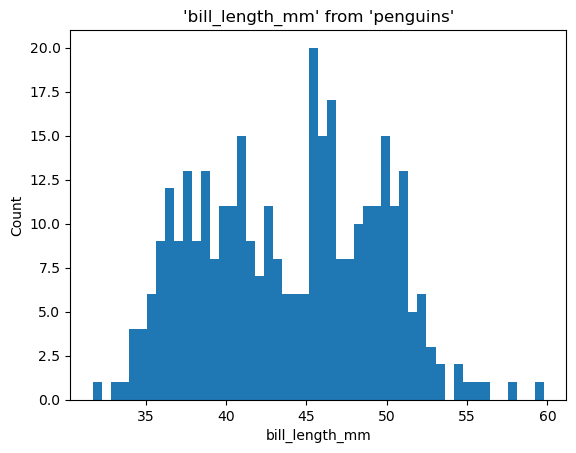

In [16]:
%sqlplot histogram --table penguins --column bill_length_mm

## Clean up

To ensure that the Python connector closes the session properly, execute `connection.close()` before `engine.dispose()`. This prevents the garbage collector from removing the resources required to communicate with Snowflake.

In [16]:
connection.close()
engine.dispose()